In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import math
import pandas as pd  
import seaborn as sns
import time

In [2]:
def read_bedgraph(path):
    """Reads the bedgraph from the path

    Returns:
        numpy array where elements look like this:
        [ chromStartPosition  chromEndPosition  dataValue]
    """
    return np.loadtxt(path, usecols=range(1,4), dtype=int)

    
    
def get_bedG_ranges(bed_columns):
    """Returns numpy array containing (chromStartPosition, chromEndPosition) 
    from the bedgraph's columns 
    Looks like this:[ [chromStartPosition  chromEndPosition] ...]
    """
    return bed_columns[: , 0:2]


def get_bedG_ranges_size(bed_columns):
    """Returns numpy array containing the size of the ranges of the bedgraph's columns
    Looks like this: [ chromEndPosition-chromStartPosition, ...] 
    """
    ranges = get_bedG_ranges(bed_columns)
    result = np.zeros(len(ranges), dtype=int)
    for i in range(len(ranges)):
        result[i] = int(ranges[i][1]-ranges[i][0])    
    return result


def get_bedG_scores(bed_columns):
    """Returns numpy array containing the values(number of reads) 
    Looks like this: [value, ...] """
    return bed_columns[:,2]


# vrati najvacsiu chromEndPosition
def get_bedG_maxPosition(bed_columns):
    """Returns the ending position of the bedgraph (biggest chromEndPosition)"""
    return bed_columns[len(bed_columns)-1][1]


In [3]:
start_time = time.time()

bed1_columns = read_bedgraph('C:\\Users\\Evi\\Documents\\2INF-LETO\\RP\\ref-miseq.bedgraph')
bed2_columns = read_bedgraph('C:\\Users\\Evi\\Documents\\2INF-LETO\\RP\\ref-nanopore.bedgraph')

print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()

bed1_ranges = get_bedG_ranges(bed1_columns)
bed1_score = get_bedG_scores(bed1_columns)   

bed2_ranges = get_bedG_ranges(bed2_columns)
bed2_score = get_bedG_scores(bed2_columns)   

print("--- %s seconds ---" % (time.time() - start_time))


--- 4.991139650344849 seconds ---
--- 0.0 seconds ---


In [4]:
from DrawDistributions import draw

def drawHistogramsForReads(ranges, score, title='Title', x_axis_name='x axis', y_axis_name='y axis', max_x=100):
    if len(ranges) != len(score):
        raise ValueError('Wrong files, the length of arrays should be equal')

    max_x=max_x

    #spravim histogram a zobrazim ho pomocou draw
    histo = {}
    for i in range(len(ranges)) :
        if int(score[i]) in histo:
            histo[int(score[i])] += (int(ranges[i][1])-int(ranges[i][0]))
        else:
            histo[int(score[i])] = (int(ranges[i][1])-int(ranges[i][0]))
    # treba vymazat 0, inak to pada
    if 0 in histo:
        del histo[0]
    data = draw(histo, max_x, title, x_axis_name, y_axis_name)
    #print(len(histo))    
    print('Maximum number of reads:', max(histo))

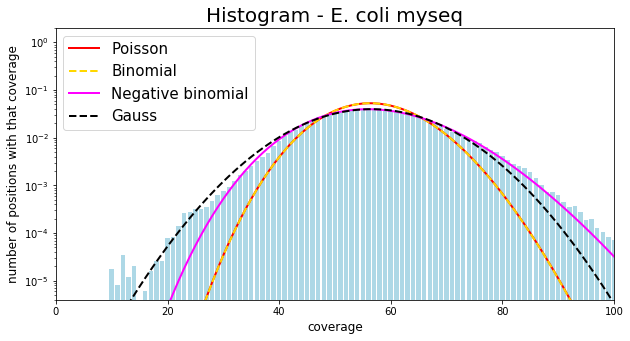

Maximum number of reads: 107


In [5]:
drawHistogramsForReads(bed1_ranges, bed1_score, title='Histogram - E. coli myseq', 
                       x_axis_name='coverage', y_axis_name='number of positions with that coverage')

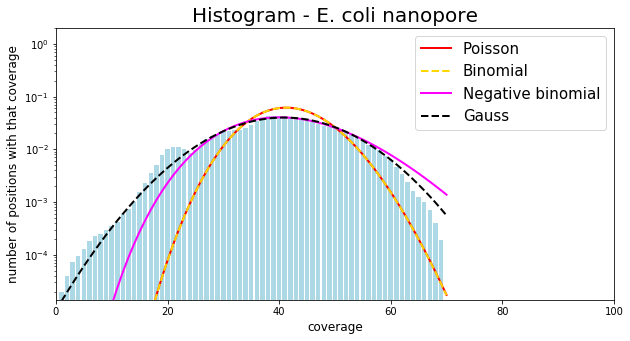

Maximum number of reads: 70


In [6]:
drawHistogramsForReads(bed2_ranges, bed2_score, title='Histogram - E. coli nanopore', 
                       x_axis_name='coverage', y_axis_name='number of positions with that coverage' )

In [7]:
#function inserts bedG_range_sizes[i] times value bedG_scores[i] 
def filler(bedG_range_sizes, bedG_scores):
    return np.repeat(bedG_scores, bedG_range_sizes)

In [8]:
bed1_range_sizes = get_bedG_ranges_size(bed1_columns)
bed2_range_sizes = get_bedG_ranges_size(bed2_columns)

bg1 = filler(bed1_range_sizes, bed1_score)
bg2 = filler(bed2_range_sizes, bed2_score)

print('Length bg1=', len(bg1))
print('Length bg2=', len(bg2))

Length bg1= 500000
Length bg2= 500000


In [9]:
def make_heatmap(x, y, title='Heatmap', colorbar_title = 'values', x_axis_name='x', y_axis_name='y', are_integers=True):
    #predpokladam, ze tie mena chromozom su v rovnakom poradi a velkost suboru je rovanaka

    #bins = nasekat rovnomerne

    plt.figure(figsize=(20,10))  
    if are_integers:
        plt.hist2d(x, y,bins=(range(max(x)), range(max(y))), cmap='plasma')
    else:
        plt.hist2d(x, y,bins=(range(max(x)), np.linspace(min(y),max(y))), cmap='plasma')


    cb = plt.colorbar()
    cb.set_label(colorbar_title, fontsize=15)

    plt.title(title, fontsize=20)
    plt.xlabel(x_axis_name, fontsize=15)
    plt.ylabel(y_axis_name, fontsize=15)

    plt.show()

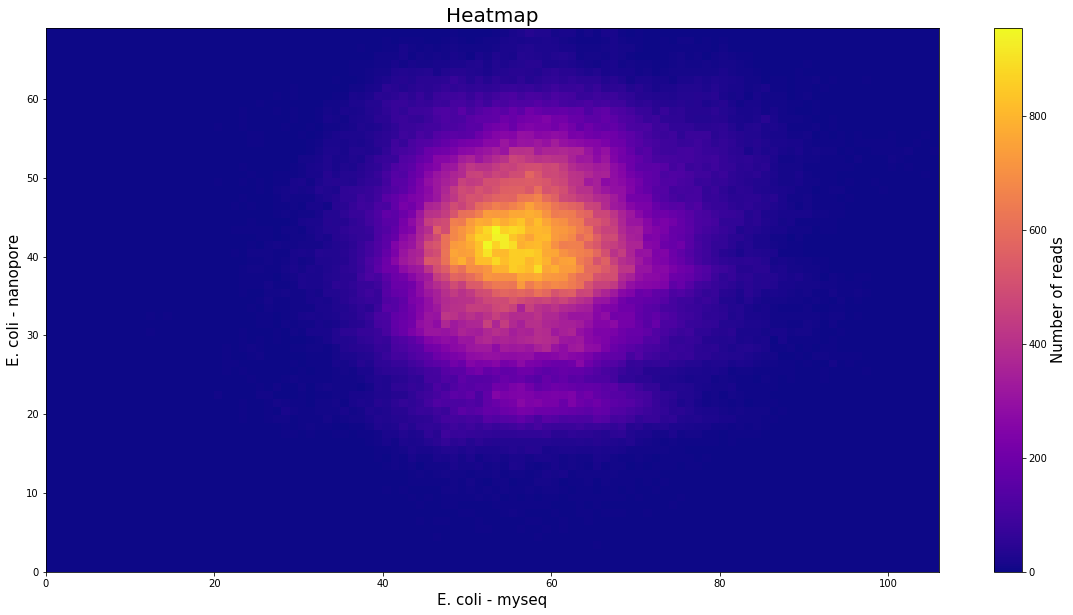

In [10]:
#bg1 = np.loadtxt('C:\\Users\\Evi\\Documents\\2INF-LETO\\project_special_data\\bg1.txt', dtype=int)
#bg2 = np.loadtxt('C:\\Users\\Evi\\Documents\\2INF-LETO\\project_special_data\\bg2.txt', dtype=int)

#print(bg1)
#print(len(bg1))

make_heatmap(bg1, bg2, title='Heatmap', colorbar_title = 'Number of reads',
             x_axis_name='E. coli - myseq', y_axis_name='E. coli - nanopore', are_integers=True)


In [11]:
def read_fasta_file(filename):
    data = []
    with open(filename) as fasta:
        for line in fasta: 
            if not line.startswith(">"):
                for c in line.strip():
                    data.append(c)
    print(len(data))
    return data

In [12]:
def create_values_from_fasta(fasta_data, kmer_length, function):
    if (kmer_length % 2 != 1):
        raise ValueError('The length of k-mer should be odd!')
    
    values = []

    half = int(kmer_length/2) 
    
    for i in range(len(fasta_data) - kmer_length +1):  # +1lebo ideme aj za posledne pismenko
        window = fasta_data[i:i+kmer_length]

        #ak su to kraje, tak napln half-krat values
        if i == 0 or i == (len(fasta_data) - kmer_length):
            # !!! pomale: values += [function(window)] * half
            values.extend(function(window) for i in range(half))
            
        #ak su to vnutorne casti
        if i >= 0 and i <= (len(fasta_data) - kmer_length):
            values.append(function(window))  
    return values
  

In [13]:
def count_GC(string):
    count = 0
    for c in string:
        if(c == 'G' or c == 'C'):
            count += 1
    return count

In [14]:
from scipy.stats import entropy

def count_entropy(string):
    length = len(string)
    if (length == 0):
        raise ValueError('Empty window!')
    probabilities = []
    probabilities.append(string.count('C')/length)
    probabilities.append(string.count('G')/length)
    probabilities.append(string.count('A')/length)
    probabilities.append(string.count('T')/length)

    return round(entropy(probabilities, base=2),2)

In [15]:
string = ['A', 'G', 'C', 'A', 'A', 'T', 'A', 'G', 'C', 'A', 'G', 'A']
print(count_entropy(string))

1.73


In [16]:
fasta_data = read_fasta_file('C:\\Users\\Evi\\Documents\\2INF-LETO\\RP\\fasta-test.txt')
got_values = create_values_from_fasta(fasta_data, 21, count_GC)
expected = [12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 14, 13, 12, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12]
ok = True
for i in range(len(expected)):
    if(expected[i]!=got_values[i]):
        ok=False

if(ok):
    print("TEST OK")
else:
    print("TEST FAILED")
    print("Expected:", expected)
    print("Got:     ", got_values)

32
TEST OK


500000


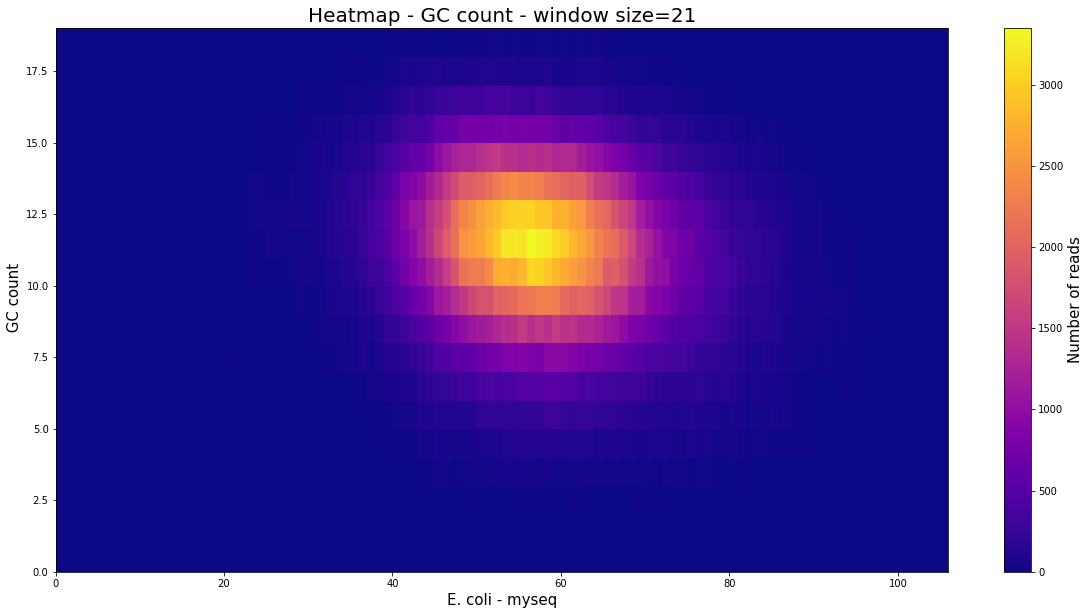

In [17]:
fasta_data = read_fasta_file('C:\\Users\\Evi\\Documents\\2INF-LETO\\RP\\ref.fasta')
values = create_values_from_fasta(fasta_data, 21, count_GC)

make_heatmap(bg1, values, title='Heatmap - GC count - window size=21', colorbar_title = 'Number of reads',
             x_axis_name='E. coli - myseq', y_axis_name=' GC count', are_integers=True)


In [18]:
def make_boxplot(x, y, title='Boxplot',  x_axis_name='x', y_axis_name='y'):
    plt.figure(figsize=(50,30))
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=30)
    plt.title(title, fontsize=80)
    plt.xlabel(x_axis_name, fontsize=50)
    plt.ylabel(y_axis_name, fontsize=50)
    sns.boxplot(x=x, y=y)
    plt.show

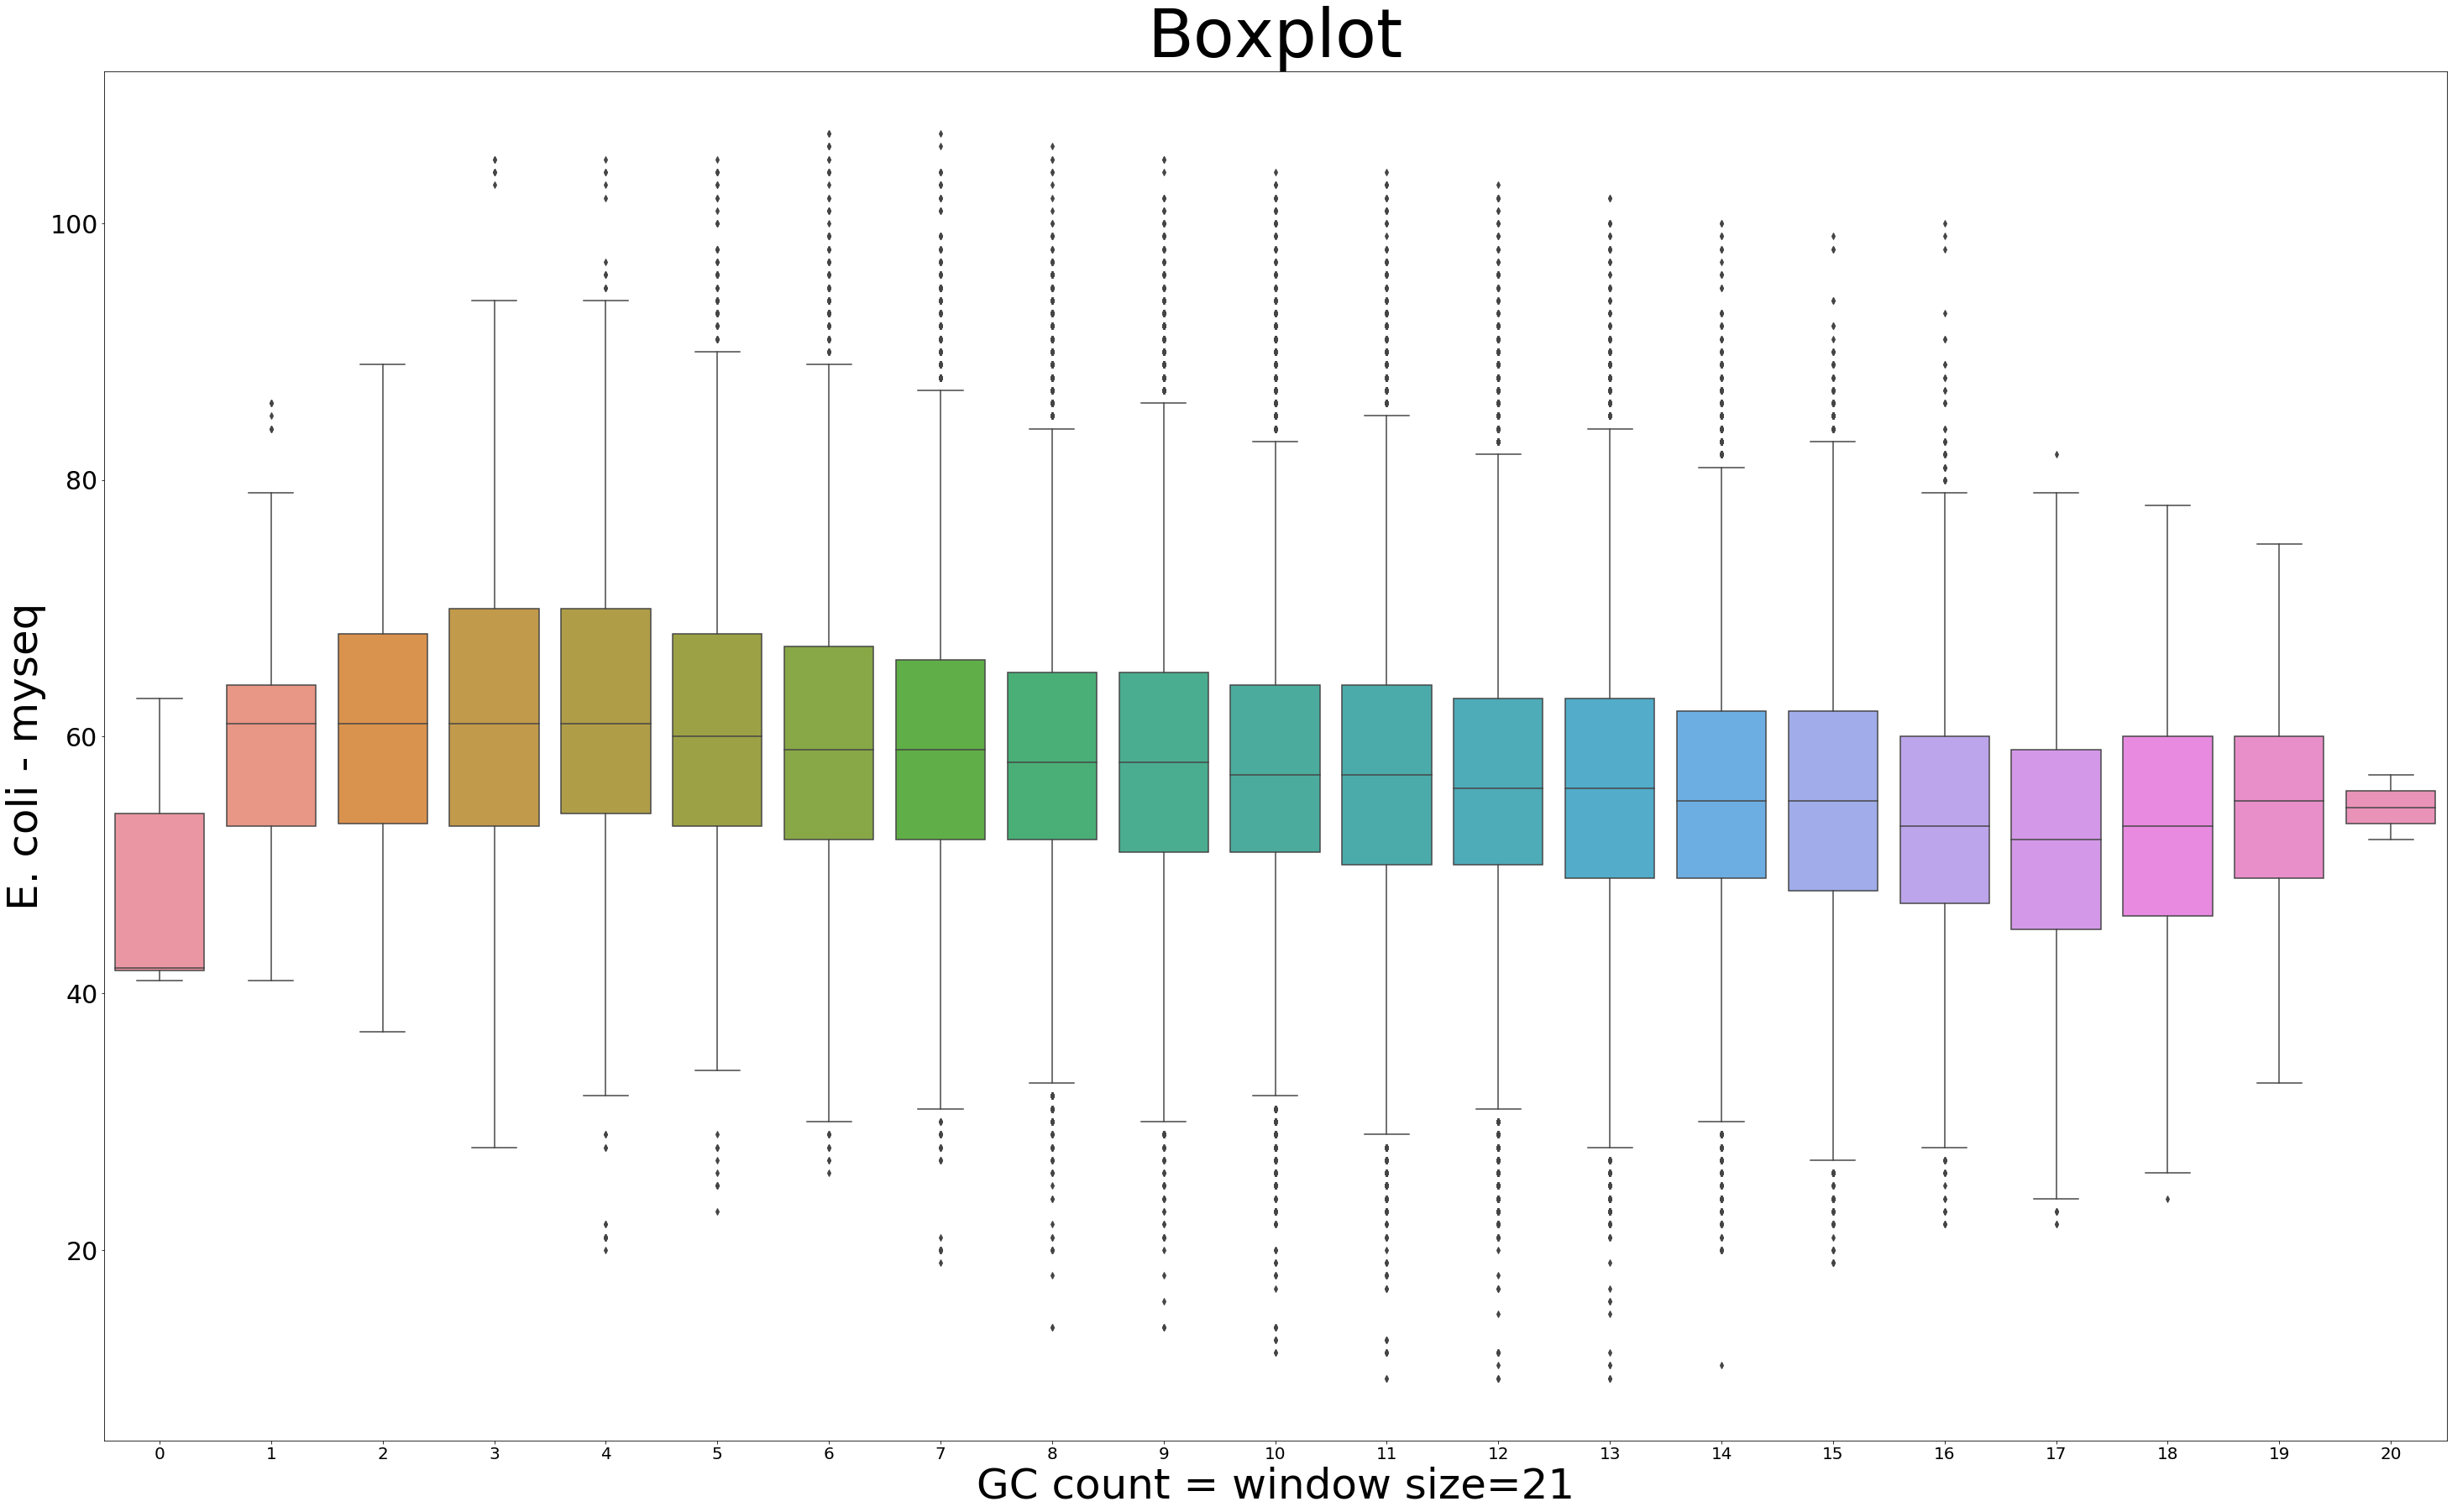

In [19]:
make_boxplot(x=values, y=bg1, title='Boxplot',  x_axis_name='GC count = window size=21', y_axis_name='E. coli - myseq')

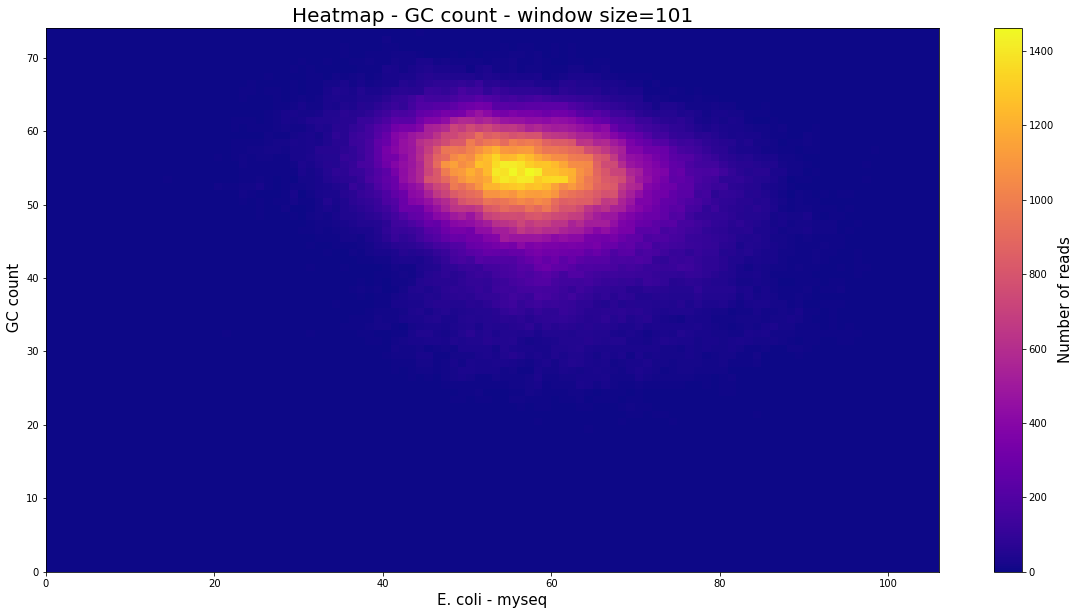

In [20]:
values = create_values_from_fasta(fasta_data, 101, count_GC)

make_heatmap(bg1, values, title='Heatmap - GC count - window size=101', colorbar_title = 'Number of reads',
             x_axis_name='E. coli - myseq', y_axis_name=' GC count', are_integers=True)

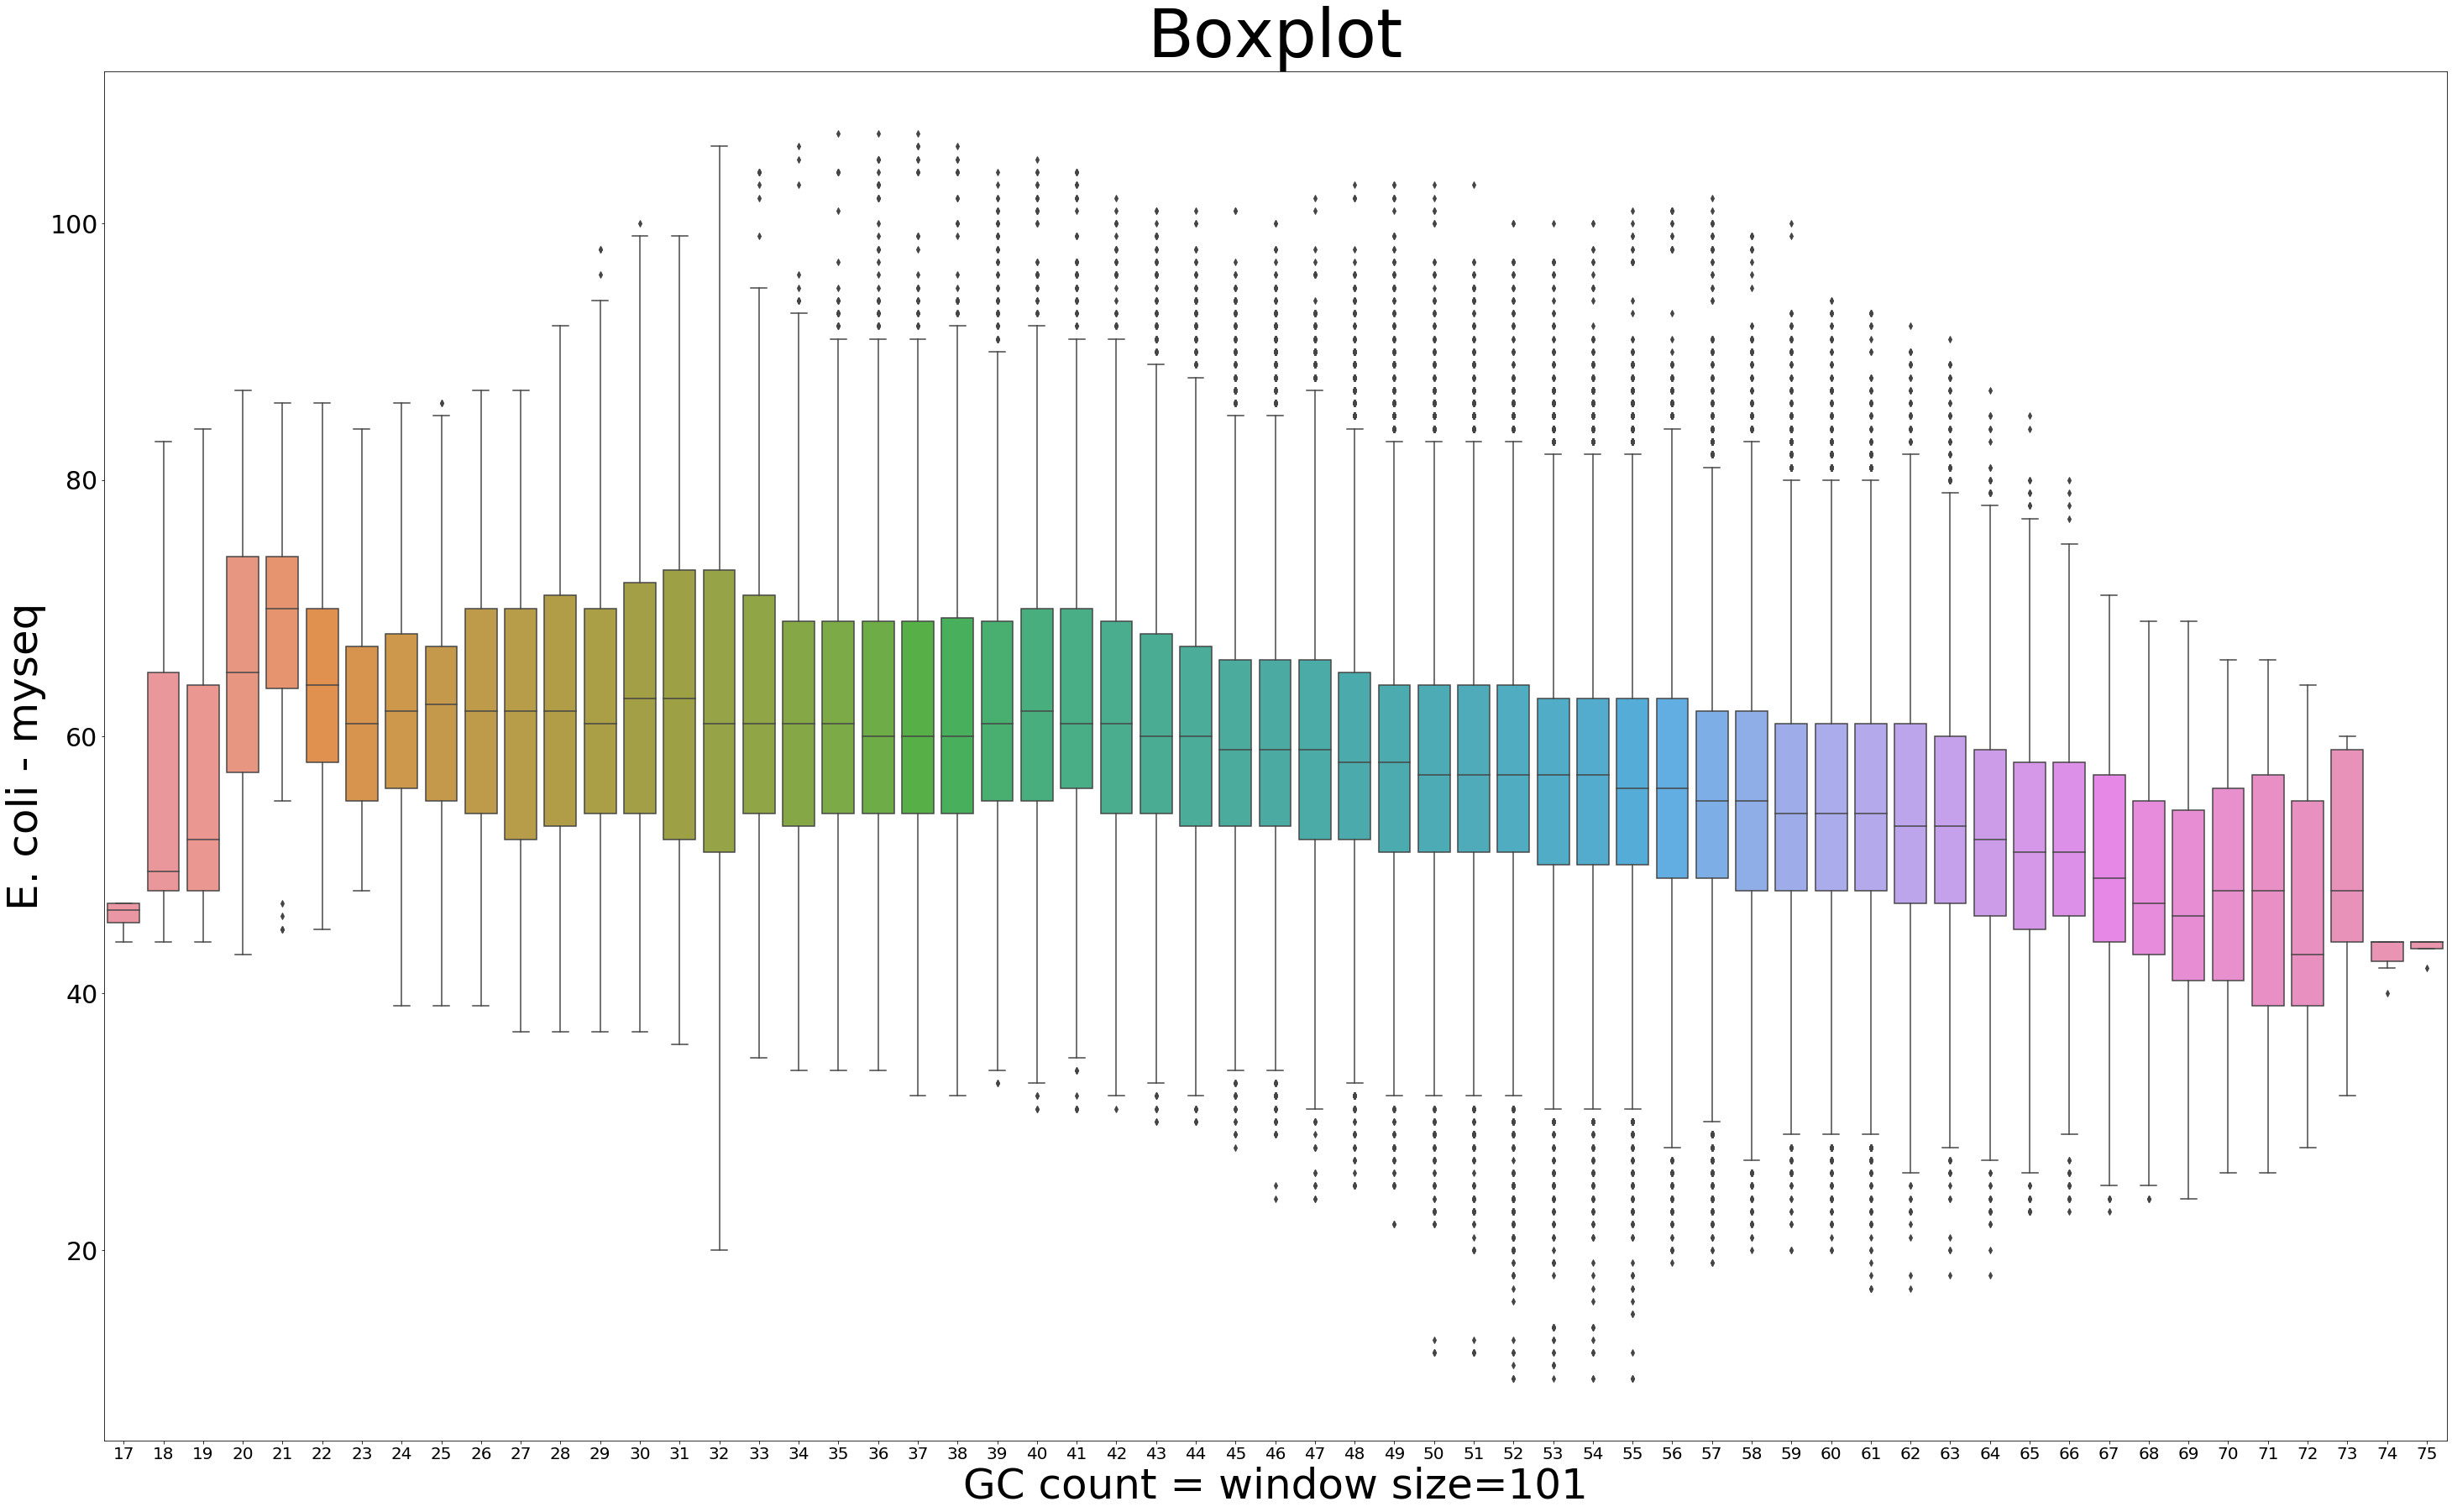

In [21]:
make_boxplot(x=values, y=bg1, title='Boxplot',  x_axis_name='GC count = window size=101', y_axis_name='E. coli - myseq')

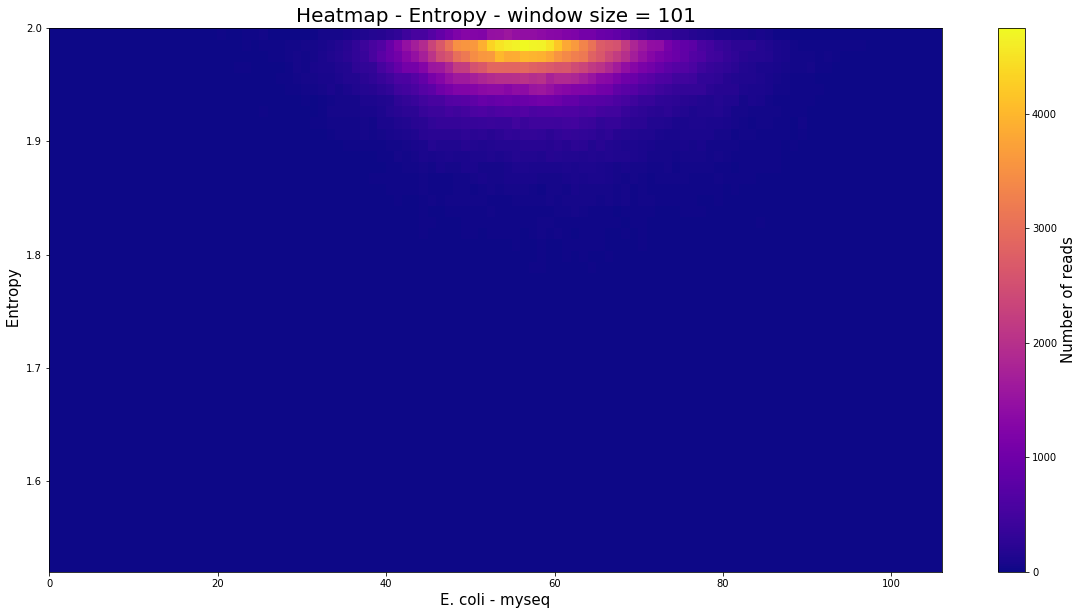

In [22]:
values = create_values_from_fasta(fasta_data, 101, count_entropy)

make_heatmap(bg1, values, title='Heatmap - Entropy - window size = 101', colorbar_title = 'Number of reads',
             x_axis_name='E. coli - myseq', y_axis_name=' Entropy', are_integers=False)

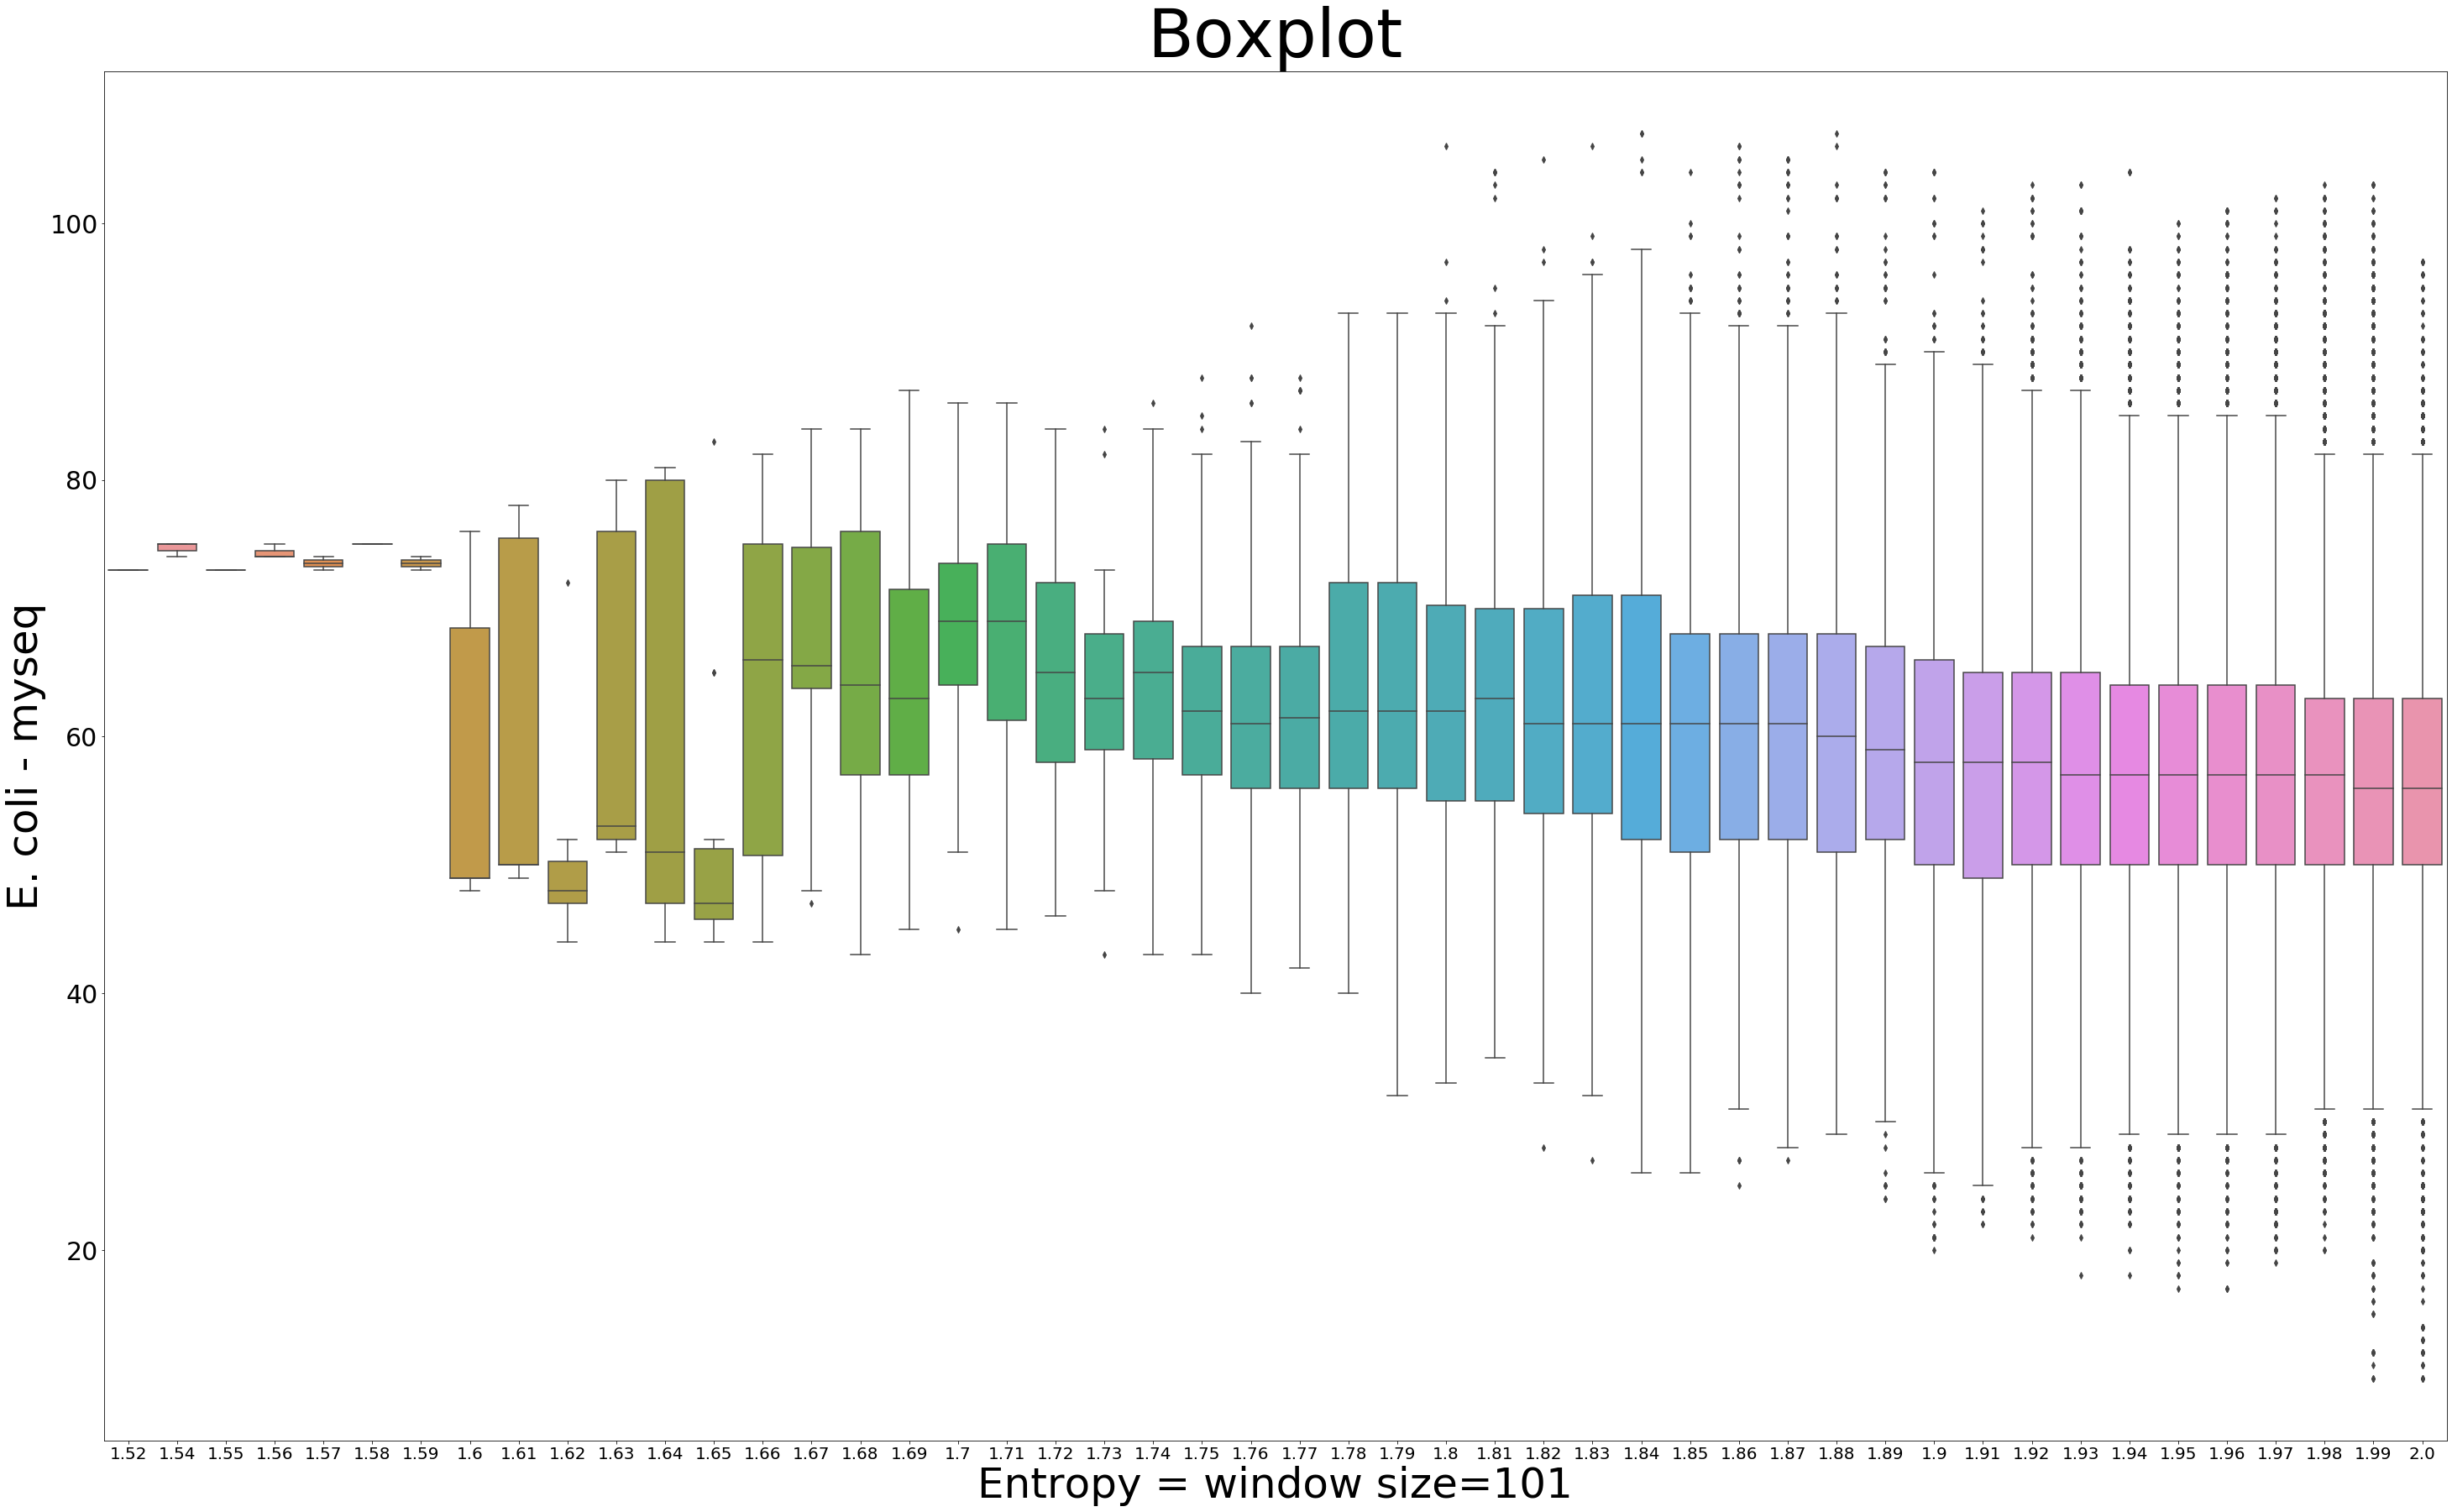

In [23]:
make_boxplot(x=values, y=bg1, title='Boxplot',  x_axis_name='Entropy = window size=101', y_axis_name='E. coli - myseq')

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

**NOT USED:**

In [25]:
############################### NOT USED ##################################################### 
# something like the filler, but the avarage of step values will be stored in the result array
# the resulting array will be step times smaller
def compressed_filler(bedG_range_sizes, bedG_scores):
    step = 40
    read_from_prev = 0
    can_read = step
   
    result = np.zeros(math.ceil(np.sum(bedG_range_sizes)/step), dtype=int)
    print(math.ceil(np.sum(bedG_range_sizes)/step))
    res_index = 0
   
    for i in range(len(bedG_range_sizes)):
        #print("i = ", i)
        while read_from_prev > 0:
            #print("while: read_from_prev = ", read_from_prev)
            read = min(step, read_from_prev)
            result[res_index] += (read * bedG_scores[i-1])
            read_from_prev -= read
            if read_from_prev > 0:
                res_index +=1
            if read_from_prev == 0:
                if read != step:
                    can_read -= read
                   
        if (can_read - bedG_range_sizes[i]) >= 0:
            #print("if: can_read  = ", can_read, " bedG_range_sizes[i] = ", bedG_range_sizes[i])
            result[res_index] += bedG_range_sizes[i] * bedG_scores[i]
            can_read -= bedG_range_sizes[i]
            if can_read == 0:
                can_read = step
                res_index += 1

        else:
            #print("else: can_read  = ", can_read, " bedG_range_sizes[i] = ", bedG_range_sizes[i])
            #print("read_from_prev = ", read_from_prev)
            result[res_index] += can_read * bedG_scores[i]
            read_from_prev = bedG_range_sizes[i] - can_read
            res_index += 1
            can_read = step
        #print("\n")
       
    for i in range(len(result)):
        if i == len(result)-1 and (len(bedG_range_sizes) % step != 0) :
            print(result[i])
            result[i] = result[i]/(step-(len(bedG_range_sizes) % step))
            print("result", result[i])
            print((step-(len(bedG_range_sizes) % step)))
        else:
            result[i] = result[i]/step
    return result

In [26]:
test_columns = read_bedgraph('C:\\Users\\Evi\\Documents\\2INF-LETO\\RP\\test.txt')
test_ranges = get_bedG_ranges(test_columns)
test_scores = get_bedG_scores(test_columns)
test_range_sizes = get_bedG_ranges_size(test_columns)

print(test_range_sizes)
print(test_scores)

vysledok = compressed_filler(np.array(test_range_sizes,dtype=int), test_scores)


#vysledok = filler(np.array(test_range_sizes,dtype=int), test_scores)
print("vysledok =",vysledok)
print(len(vysledok))



[ 1 10  2  1  4  2  1  4  3  3  6  1  2  1]
[20 21 22 23 25 26 27 28 29 30 31 32 20 35]
2
35
result 1
26
vysledok = [25  1]
2


In [27]:
bed1_range_sizes = get_bedG_ranges_size(bed1_columns)
bed2_range_sizes = get_bedG_ranges_size(bed2_columns)

#bg1 = compressed_filler(bed1_range_sizes, bed1_score)
#bg2 = compressed_filler(bed2_range_sizes, bed2_score)

bg1 = filler(bed1_range_sizes, bed1_score)
bg2 = filler(bed2_range_sizes, bed2_score)

np.savetxt('bg1.txt', bg1, fmt='%5.0f')
np.savetxt('bg2.txt', bg2, fmt='%5.0f')

%reset array

bg1 = np.loadtxt('bg1.txt', dtype=int)
bg2 = np.loadtxt('bg2.txt', dtype=int)

print('Length bg1=', len(bg1))
print('Length bg2=', len(bg2))

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Length bg1= 500000
Length bg2= 500000
